**<font size="6">Script para encontrar muestra representativa de paciente</font>**

<dl>
<dt>Pasos:</dt>
    <dd>- Buscar frame en el que la dilatación es máxima</dd>
    <dd>- Elegir todos los slices asociados a ese tiempo</dd>
    <dd>- Eliminar ruido </dd>
    <dd>- Centrar imágenes</dd>
    <dd>- Guardar imagen cambiando el formato de RGBA a RGB</dd>
</dl>

In [3]:
# Program: <MAX_SLICES.ipynb>
# Author: Marc Bracons Cucó
# Affiliation: Department of Telecommunication and Systems Engineering, Autonomous University of Barcelona, Wireless Information Networking Group
# Copyright © 2023 Marc Bracons Cucó
# 
# This program is proprietary software; you may not use, distribute, or modify it 
# without the explicit permission of the author.
#
# If you wish to use this program in your work, please, contact the author.

**<font size="4">ESTRUCTURA DEL DATASET</font>**
<dl>Buscaremos en todas las carpetas "recortes" de un mismo paciente "_x" los 3 slices más grandes.
Para ellos contaremos píxeles, ya que es un método muy rápido de selección.</dl>

**<font size = "4">Obtención de muestra representante de cada frame</font>**

Contamos los píxeles no vacíos (valor alpha != 0 en imagen RGBA) de cada carpetas recortes y escogemos al representante.

In [68]:
# Specify the patient folder
patient_folder = "/home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/"  # Cambiar este path por el del paciente que quieras

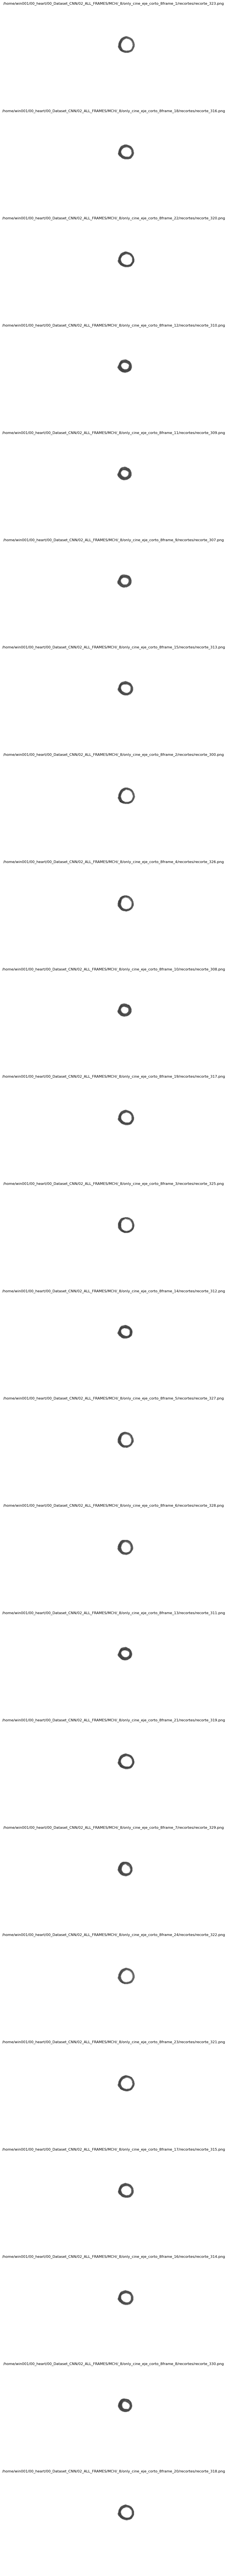

In [69]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def count_pixels(patient_folder):
    best_image_per_folder = {}
    max_pixels_per_folder = {}
    for root, dirs, files in os.walk(patient_folder):
        if 'recortes' in root:
            best_image = ''
            max_pixels = 0
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    with Image.open(file_path) as img:
                        np_img = np.array(img)
                        pixel_count = np.sum(np_img[:, :, 3] != 0)
                        if pixel_count > max_pixels:
                            max_pixels = pixel_count
                            best_image = file_path
            best_image_per_folder[root] = best_image
            max_pixels_per_folder[root] = max_pixels
    return best_image_per_folder, max_pixels_per_folder

def plot_images(images):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, 5*len(images)))
    for i, (folder, img_path) in enumerate(images.items()):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].set_title(f'{img_path}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

best_images_per_folder, _ = count_pixels(patient_folder)  # Ignore the pixel counts for now
plot_images(best_images_per_folder)

**<font size="4">Elección del frame</font>**

<dl>Usando la transformada de Hough, veremos a que sección de las representativas se le puede ajustar un círculo de mayor radio</dl>

Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_1/recortes/recorte_323.png, circle radius: 20, pixels: 1015
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_18/recortes/recorte_316.png, circle radius: 15, pixels: 997
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_22/recortes/recorte_320.png, circle radius: 15, pixels: 1004
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_12/recortes/recorte_310.png, circle radius: 10, pixels: 939
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_11/recortes/recorte_309.png, circle radius: 10, pixels: 934
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_9/recortes/recorte_307.png, circle radius: 10, pixels: 911
Processing image: /hom

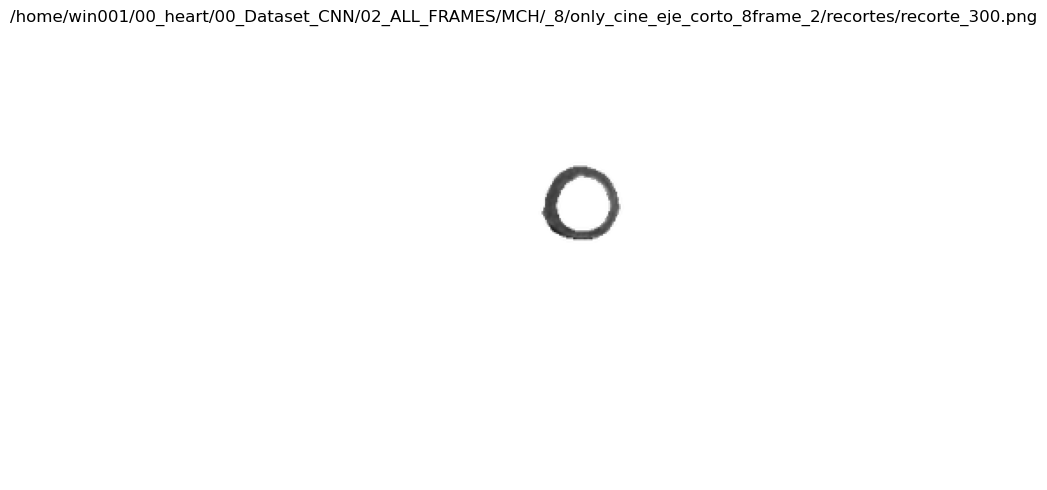

In [70]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks

def count_pixels(patient_folder):
    best_image_per_folder = {}
    max_pixels_per_folder = {}
    for root, dirs, files in os.walk(patient_folder):
        if 'recortes' in root:
            best_image = ''
            max_pixels = 0
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    with Image.open(file_path) as img:
                        np_img = np.array(img)
                        pixel_count = np.sum(np_img[:, :, 3] != 0)
                        if pixel_count > max_pixels:
                            max_pixels = pixel_count
                            best_image = file_path
            best_image_per_folder[root] = best_image
            max_pixels_per_folder[root] = max_pixels
    return best_image_per_folder, max_pixels_per_folder

def find_biggest_circle(images, pixel_counts):
    max_radius = 0
    max_image = None
    max_radius_images = []
    for folder, image_path in images.items():
        with Image.open(image_path) as img:
            np_img = np.array(img.convert("L"))  # Convert the image to grayscale
            hough_radii = np.arange(10, 200, 1)
            hough_res = hough_circle(np_img, hough_radii)
            accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
            if radii[0] > max_radius:
                max_radius = radii[0]
                max_radius_images = [(folder, image_path)]
            elif radii[0] == max_radius:
                max_radius_images.append((folder, image_path))
        print(f"Processing image: {image_path}, circle radius: {radii[0]}, pixels: {pixel_counts[folder]}")
    
    if len(max_radius_images) == 1:
        max_image = max_radius_images[0][1]
    elif len(max_radius_images) > 1:
        max_pixels = max(pixel_counts[folder] for folder, _ in max_radius_images)
        max_pixels_images = [(folder, image_path) for folder, image_path in max_radius_images if pixel_counts[folder] == max_pixels]
        if len(max_pixels_images) == 1:
            max_image = max_pixels_images[0][1]
        else:
            print("Más de un representante posible:")
            for folder, image_path in max_pixels_images:
                print(f"Ruta imagen: {image_path}")
    
    return max_image, os.path.dirname(max_image)

def plot_images(images):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, 5*len(images)))
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        if len(images) > 1:
            axs[i].imshow(img)
            axs[i].set_title(f'{img_path}')
            axs[i].axis('off')
        else:
            axs.imshow(img)
            axs.set_title(f'{img_path}')
            axs.axis('off')
    plt.tight_layout()
    plt.show()

best_images_per_folder, max_pixels_per_folder = count_pixels(patient_folder)
biggest_circle_image, folder_path = find_biggest_circle(best_images_per_folder, max_pixels_per_folder)

if biggest_circle_image is not None:
    print(f"La imagen elegida es: {biggest_circle_image}")
    print(f"La carpeta donde se encuentra la imagen es: {folder_path}")
    plot_images([biggest_circle_image])
else:
    print("No hay imágenes para mostrar.")

**<font size="4">Mostrar slices del frame seleccionado</font>**

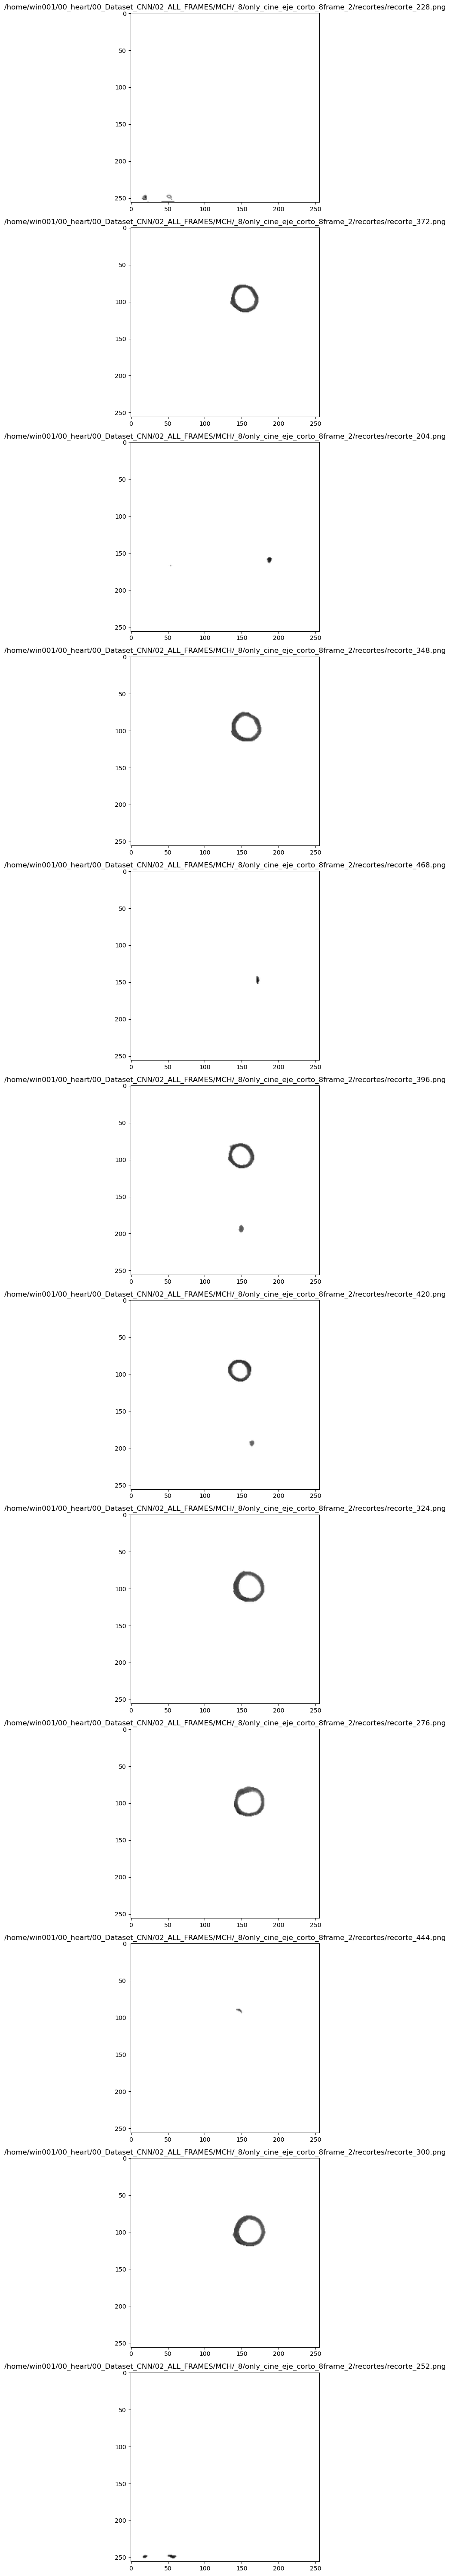

In [71]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_all_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        if file.endswith('.png'):
            image_path = os.path.join(folder_path, file)
            images.append(image_path)
    
    if len(images) > 0:
        plot_images(images)
    else:
        print("No se encontraron imágenes en la carpeta.")

def plot_images(images):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, 5*len(images)))
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        if len(images) > 1:
            axs[i].imshow(img)
            axs[i].set_title(f'{img_path}')
            axs[i].axis('on')
        else:
            axs.imshow(img)
            axs.set_title(f'{img_path}')
            axs.axis('on')
    plt.tight_layout()
    plt.show()

show_all_images(folder_path)

**<font size="4">Procesado de las slices del frame seleccionado</font>**

<dl>
<dt>Pasos:</dt>
    <dd>- Calculamos transformada de Hough para cada imágen</dd>
    <dd>- Centrar imágen</dd>
    <dd>- Rellenar huecos con píxeles de valor alfa = 0</dd>
</dl>

In [72]:
#folder_path = "/home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_2/only_cine_eje_corto_2frame_3/recortes"  # Cambiar por la ruta de la carpeta deseada

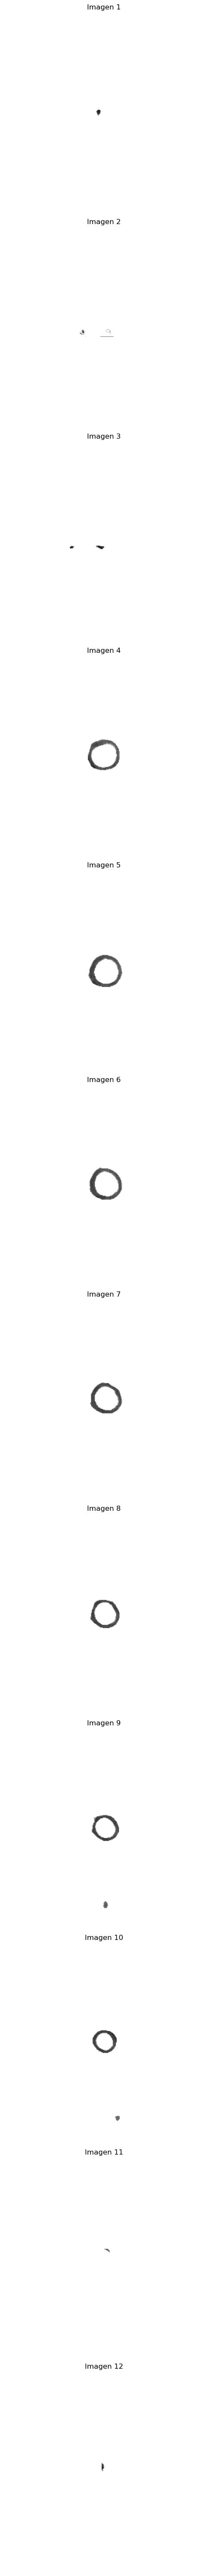

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.transform import hough_circle, hough_circle_peaks

def process_images_in_folder(folder_path):
    images = sorted(os.listdir(folder_path))

    fig, axs = plt.subplots(len(images), 1, figsize=(5, 5*len(images)))
    
    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Cargar la imagen
        image = Image.open(image_path)

        # Convertir la imagen a modo binario (blanco y negro)
        image_bin = image.convert("1")

        # Obtener la matriz de píxeles de la imagen binaria
        pixels = image_bin.load()

        # Convertir la imagen binaria a una matriz NumPy
        image_array = np.array(image_bin)

        # Configurar los parámetros de la transformada de Hough circular
        radius_min = 10  # Radio mínimo del círculo a buscar
        radius_max = 200  # Radio máximo del círculo a buscar

        # Aplicar la transformada de Hough circular
        hough_radii = np.arange(radius_min, radius_max + 1)
        hough_result = hough_circle(image_array, hough_radii)

        # Encontrar los parámetros del círculo
        accums, cx, cy, radii = hough_circle_peaks(hough_result, hough_radii, total_num_peaks=1)

        # Comprobar si se encontró un círculo
        if len(cx) == 0:
            # No se encontró un círculo en la imagen, omitir esta imagen
            continue

        # Obtener los parámetros del círculo encontrado
        center_x = cx[0]
        center_y = cy[0]
        radius = radii[0]

        # Calcular el desplazamiento para centrar la imagen en base al círculo
        displacement_x = int(image.size[0] / 2 - center_x)
        displacement_y = int(image.size[1] / 2 - center_y)

        # Crear una nueva imagen centrada
        centered_image = Image.new("RGBA", image.size)
        centered_image.paste(image, (displacement_x, displacement_y))

        # Crear una máscara con los píxeles con valor de alfa igual a 0
        alpha_mask = centered_image.split()[3]
        filled_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
        filled_image.paste(centered_image, (0, 0), mask=alpha_mask)

        # Mostrar la imagen centrada
        axs[i].imshow(filled_image)
        axs[i].set_title(f"Imagen {i+1}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Especificar la carpeta de imágenes
process_images_in_folder(folder_path)

**<font size="4">Eliminamos muestras no válidas y ruido</font>**

<dl>
<dt>Pasos:</dt>
    <dd>- Si cantidad de píxeles con alfa diferente de 0 < umbral -> ignorar esa imágen</dd>
    <dd>- Ampliar transformada de Hough 20 píxeles</dd>
    <dd>- Eliminar píxeles que queden fuera del círculo ampliado = 0</dd>
</dl>

Eliminación de ruido

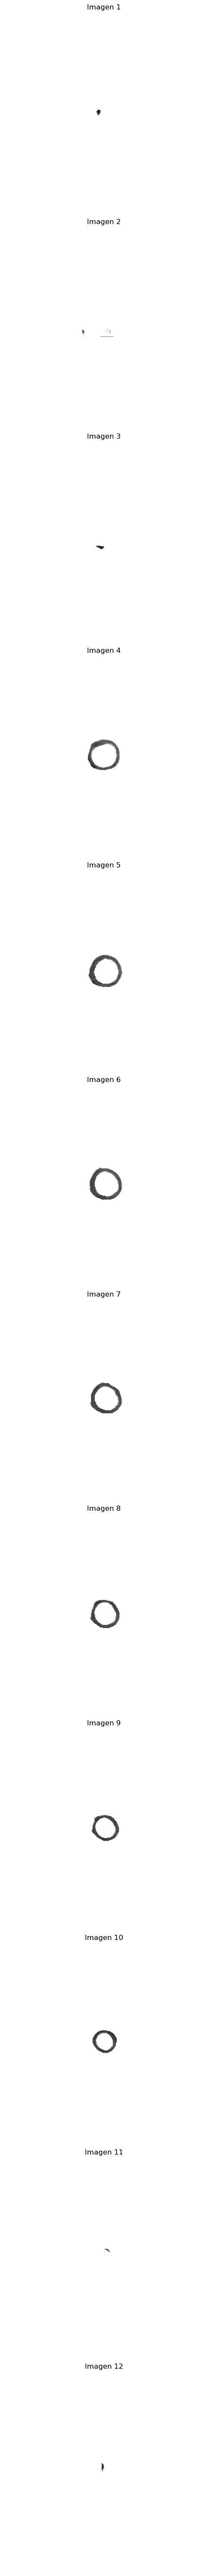

In [81]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.transform import hough_circle, hough_circle_peaks

def process_images_in_folder(folder_path):
    images = sorted(os.listdir(folder_path))

    fig, axs = plt.subplots(len(images), 1, figsize=(5, 5*len(images)))
    
    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Cargar la imagen
        image = Image.open(image_path)

        # Convertir la imagen a modo binario (blanco y negro)
        image_bin = image.convert("1")

        # Obtener la matriz de píxeles de la imagen binaria
        pixels = image_bin.load()

        # Convertir la imagen binaria a una matriz NumPy
        image_array = np.array(image_bin)

        # Configurar los parámetros de la transformada de Hough circular
        radius_min = 10  # Radio mínimo del círculo a buscar
        radius_max = 200  # Radio máximo del círculo a buscar

        # Aplicar la transformada de Hough circular
        hough_radii = np.arange(radius_min, radius_max + 1)
        hough_result = hough_circle(image_array, hough_radii)

        # Encontrar los parámetros del círculo
        accums, cx, cy, radii = hough_circle_peaks(hough_result, hough_radii, total_num_peaks=1)

        # Comprobar si se encontró un círculo
        if len(cx) == 0:
            # No se encontró un círculo en la imagen, omitir esta imagen
            continue

        # Obtener los parámetros del círculo encontrado
        center_x = cx[0]
        center_y = cy[0]
        radius = radii[0]

        # Calcular el desplazamiento para centrar la imagen en base al círculo
        displacement_x = int(image.size[0] / 2 - center_x)
        displacement_y = int(image.size[1] / 2 - center_y)

        # Crear una nueva imagen centrada
        centered_image = Image.new("RGBA", image.size)
        centered_image.paste(image, (displacement_x, displacement_y))

        # Crear un círculo ampliado alrededor del centro de la imagen
        expanded_radius = radius + 20  # Radio del círculo ampliado
        image_center_x = centered_image.size[0] // 2
        image_center_y = centered_image.size[1] // 2
        for y in range(centered_image.size[1]):
            for x in range(centered_image.size[0]):
                # Calcular la distancia al centro de la imagen
                distance = ((x - image_center_x) ** 2 + (y - image_center_y) ** 2) ** 0.5
                if distance > expanded_radius:
                    # Si el píxel está fuera del círculo ampliado, hacerlo transparente
                    centered_image.putpixel((x, y), (0, 0, 0, 0))

        # Crear una máscara con los píxeles con valor de alfa igual a 0
        alpha_mask = centered_image.split()[3]
        filled_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
        filled_image.paste(centered_image, (0, 0), mask=alpha_mask)

        # Mostrar la imagen centrada
        axs[i].imshow(filled_image)
        axs[i].set_title(f"Imagen {i+1}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Especificar la carpeta de imágenes
process_images_in_folder(folder_path)

In [4]:
folder_path = "/home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/MCH/_8/only_cine_eje_corto_8frame_2/recortes"

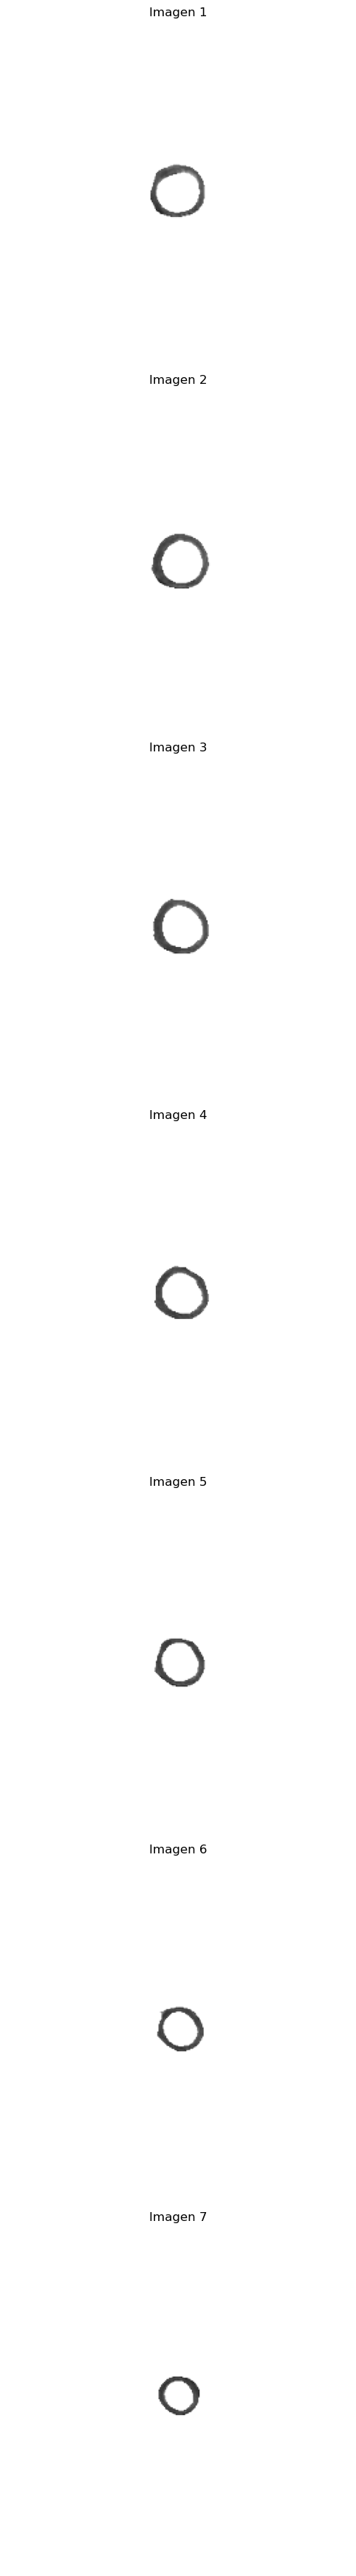

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.transform import hough_circle, hough_circle_peaks

def process_images_in_folder(folder_path):
    images = sorted(os.listdir(folder_path))

    processed_images = []

    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Cargar la imagen
        image = Image.open(image_path)

        # Contar los píxeles con alfa diferente de 0
        alpha_pixel_count = 0
        for y in range(image.size[1]):
            for x in range(image.size[0]):
                if image.getpixel((x, y))[3] != 0:
                    alpha_pixel_count += 1
        
        # Ignorar la imagen si tiene menos de 50 píxeles con alfa diferente de 0
        if alpha_pixel_count < 250:
            continue

        # Convertir la imagen a modo binario (blanco y negro)
        image_bin = image.convert("1")

        # Obtener la matriz de píxeles de la imagen binaria
        pixels = image_bin.load()

        # Convertir la imagen binaria a una matriz NumPy
        image_array = np.array(image_bin)

        # Configurar los parámetros de la transformada de Hough circular
        radius_min = 10  # Radio mínimo del círculo a buscar
        radius_max = 200  # Radio máximo del círculo a buscar

        # Aplicar la transformada de Hough circular
        hough_radii = np.arange(radius_min, radius_max + 1)
        hough_result = hough_circle(image_array, hough_radii)

        # Encontrar los parámetros del círculo
        accums, cx, cy, radii = hough_circle_peaks(hough_result, hough_radii, total_num_peaks=1)

        # Comprobar si se encontró un círculo
        if len(cx) == 0:
            # No se encontró un círculo en la imagen, omitir esta imagen
            continue

        # Obtener los parámetros del círculo encontrado
        center_x = cx[0]
        center_y = cy[0]
        radius = radii[0]

        # Calcular el desplazamiento para centrar la imagen en base al círculo
        displacement_x = int(image.size[0] / 2 - center_x)
        displacement_y = int(image.size[1] / 2 - center_y)

        # Crear una nueva imagen centrada
        centered_image = Image.new("RGBA", image.size)
        centered_image.paste(image, (displacement_x, displacement_y))

        # Crear un círculo ampliado alrededor del centro de la imagen
        expanded_radius = radius + 20  # Radio del círculo ampliado
        image_center_x = centered_image.size[0] // 2
        image_center_y = centered_image.size[1] // 2
        for y in range(centered_image.size[1]):
            for x in range(centered_image.size[0]):
                # Calcular la distancia al centro de la imagen
                distance = ((x - image_center_x)**2 + (y - image_center_y)**2)**0.5
                # Eliminar los píxeles fuera del círculo ampliado
                if distance > expanded_radius:
                    centered_image.putpixel((x, y), (0, 0, 0, 0))

        # Crear una máscara con los píxeles con valor de alfa igual a 0
        alpha_mask = centered_image.split()[3]
        filled_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
        filled_image.paste(centered_image, (0, 0), mask=alpha_mask)

        processed_images.append(filled_image)

    fig, axs = plt.subplots(len(processed_images), 1, figsize=(5, 5*len(processed_images)))

    for i, image in enumerate(processed_images):
        axs[i].imshow(image)
        axs[i].set_title(f"Imagen {i+1}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Especificar la carpeta de imágenes
process_images_in_folder(folder_path)

<dl>Guardado de imágenes:
    <dt>- Se guardan las imágenes en la carpeta seleccionada, se mantiene el nombre de "only_cine_eje_corto_xframe_y"</dt>
        <dd> x indica el ID del paciente, y el frame seleccionado
    <dt>- Se cambian las imágenes de formato RGBA a RGB para poder trabajar con modelos pre-entrenados</dt>
</dl>

In [5]:
import os
import numpy as np
from PIL import Image, ImageDraw
from skimage.transform import hough_circle, hough_circle_peaks

def process_images_in_folder(folder_path):
    images = sorted(os.listdir(folder_path))

    # Obtener el nombre de la carpeta del paciente a partir de la ruta de las imágenes originales
    patient_folder = os.path.basename(os.path.dirname(folder_path))

    # Crear la carpeta en la que se guardarán las imágenes procesadas, si no existe
    output_folder = os.path.join("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/test", patient_folder)
    os.makedirs(output_folder, exist_ok=True)

    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Cargar la imagen
        image = Image.open(image_path)

        # Contar los píxeles con alfa diferente de 0
        alpha_pixel_count = 0
        for y in range(image.size[1]):
            for x in range(image.size[0]):
                if image.getpixel((x, y))[3] != 0:
                    alpha_pixel_count += 1
        
        # Ignorar la imagen si tiene menos de 50 píxeles con alfa diferente de 0
        if alpha_pixel_count < 250:
            continue

        # Convertir la imagen a modo binario (blanco y negro)
        image_bin = image.convert("1")

        # Obtener la matriz de píxeles de la imagen binaria
        pixels = image_bin.load()

        # Convertir la imagen binaria a una matriz NumPy
        image_array = np.array(image_bin)

        # Configurar los parámetros de la transformada de Hough circular
        radius_min = 10  # Radio mínimo del círculo a buscar
        radius_max = 200  # Radio máximo del círculo a buscar

        # Aplicar la transformada de Hough circular
        hough_radii = np.arange(radius_min, radius_max + 1)
        hough_result = hough_circle(image_array, hough_radii)

        # Encontrar los parámetros del círculo
        accums, cx, cy, radii = hough_circle_peaks(hough_result, hough_radii, total_num_peaks=1)

        # Comprobar si se encontró un círculo
        if len(cx) == 0:
            # No se encontró un círculo en la imagen, omitir esta imagen
            continue

        # Obtener los parámetros del círculo encontrado
        center_x = cx[0]
        center_y = cy[0]
        radius = radii[0]

        # Calcular el desplazamiento para centrar la imagen en base al círculo
        displacement_x = int(image.size[0] / 2 - center_x)
        displacement_y = int(image.size[1] / 2 - center_y)

        # Crear una nueva imagen centrada
        centered_image = Image.new("RGBA", image.size)
        centered_image.paste(image, (displacement_x, displacement_y))

        # Crear un círculo ampliado alrededor del centro de la imagen
        expanded_radius = radius + 20  # Radio del círculo ampliado
        image_center_x = centered_image.size[0] // 2
        image_center_y = centered_image.size[1] // 2
        for y in range(centered_image.size[1]):
            for x in range(centered_image.size[0]):
                # Calcular la distancia al centro de la imagen
                distance = ((x - image_center_x)**2 + (y - image_center_y)**2)**0.5
                # Eliminar los píxeles fuera del círculo ampliado
                if distance > expanded_radius:
                    centered_image.putpixel((x, y), (0, 0, 0, 0))

        # Crear una máscara con los píxeles con valor de alfa igual a 0
        alpha_mask = centered_image.split()[3]
        filled_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
        filled_image.paste(centered_image, (0, 0), mask=alpha_mask)

        # Guardar la imagen procesada en formato RGB
        rgb_image = filled_image.convert("RGB")
        rgb_image.save(os.path.join(output_folder, f"processed_{image_name}"))

# Especificar la carpeta de imágenes
process_images_in_folder(folder_path)

**<font size="6">Función que cumpla todos los pasos</font>**

In [2]:
#librerías
import os
import re
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks

**<font size="4">versiones finales de las funciones previas</font>**
<dl>
    <dt>count_pixels:</dt>
        <dd>- sin cambios</dd>
    <dt>find_biggest_circle:</dt>
        <dd>- Añadido modo de selección en caso de más de un posible representante (menor frame posible)</dd>
    <dt>process_images_in_folder:</dt>
        <dd>- modificado para que al generalizar para todos los directorios se mueva corractamente por el dataset y guarde imágenes en directorio correcto</dd>
</dl>

In [2]:
def count_pixels(patient_folder):
    best_image_per_folder = {}
    max_pixels_per_folder = {}
    for root, dirs, files in os.walk(patient_folder):
        if 'recortes' in root:
            best_image = ''
            max_pixels = 0
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    with Image.open(file_path) as img:
                        np_img = np.array(img)
                        pixel_count = np.sum(np_img[:, :, 3] != 0)
                        if pixel_count > max_pixels:
                            max_pixels = pixel_count
                            best_image = file_path
            best_image_per_folder[root] = best_image
            max_pixels_per_folder[root] = max_pixels
    return best_image_per_folder, max_pixels_per_folder

In [3]:
def find_biggest_circle(images, pixel_counts):
    max_radius = 0
    max_image = None
    max_radius_images = []
    for folder, image_path in images.items():
        with Image.open(image_path) as img:
            np_img = np.array(img.convert("L"))  # Convert the image to grayscale
            hough_radii = np.arange(10, 200, 1)
            hough_res = hough_circle(np_img, hough_radii)
            accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
            if radii[0] > max_radius:
                max_radius = radii[0]
                max_radius_images = [(folder, image_path)]
            elif radii[0] == max_radius:
                max_radius_images.append((folder, image_path))
        print(f"Processing image: {image_path}, circle radius: {radii[0]}, pixels: {pixel_counts[folder]}")
    
    if len(max_radius_images) == 1:
        max_image = max_radius_images[0][1]
    elif len(max_radius_images) > 1:
        max_pixels = max(pixel_counts[folder] for folder, _ in max_radius_images)
        max_pixels_images = [(folder, image_path) for folder, image_path in max_radius_images if pixel_counts[folder] == max_pixels]
        if len(max_pixels_images) == 1:
            max_image = max_pixels_images[0][1]
        else:
            print("Más de un representante posible:")
            frame_paths = []
            for folder, image_path in max_pixels_images:
                print(f"Ruta imagen: {image_path}")
                # Regex to match the 'only_cine_eje_corto_<id>frame_<frame_num>'
                match = re.search(r'only_cine_eje_corto_\d+frame_(\d+)', image_path)
                if match:
                    frame_num = int(match.group(1))  # Get frame number from regex match
                    frame_paths.append((frame_num, image_path))
            # Sort the paths by frame number in ascending order and select the one with the smallest frame number
            frame_paths.sort(key=lambda x: x[0])
            max_image = frame_paths[0][1]
    
    return max_image, os.path.dirname(max_image)

In [4]:
def process_images_in_folder(folder_path):
    images = sorted(os.listdir(folder_path))

    # Obtener la carpeta anterior a la carpeta del paciente
    parent_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(folder_path))))

    # Determinar la carpeta de salida en función de la carpeta anterior
    if parent_folder == "MCH":
        output_folder = os.path.join("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes", "MCH")
        print("Carpeta de salida: MCH")
    elif parent_folder == "Otros":
        output_folder = os.path.join("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes", "Otros")
        print("Carpeta de salida: Otros")
    else:
        # Si la carpeta anterior no es "MCH" ni "Otros", no se guarda la imagen procesada
        print("Carpeta anterior no válida:", parent_folder)
        return

    os.makedirs(output_folder, exist_ok=True)

    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Cargar la imagen
        image = Image.open(image_path)

        # Contar los píxeles con alfa diferente de 0
        alpha_pixel_count = 0
        for y in range(image.size[1]):
            for x in range(image.size[0]):
                if image.getpixel((x, y))[3] != 0:
                    alpha_pixel_count += 1
        
        # Ignorar la imagen si tiene menos de 50 píxeles con alfa diferente de 0
        if alpha_pixel_count < 250:
            continue

        # Convertir la imagen a modo binario (blanco y negro)
        image_bin = image.convert("1")

        # Obtener la matriz de píxeles de la imagen binaria
        pixels = image_bin.load()

        # Convertir la imagen binaria a una matriz NumPy
        image_array = np.array(image_bin)

        # Configurar los parámetros de la transformada de Hough circular
        radius_min = 10  # Radio mínimo del círculo a buscar
        radius_max = 200  # Radio máximo del círculo a buscar

        # Aplicar la transformada de Hough circular
        hough_radii = np.arange(radius_min, radius_max + 1)
        hough_result = hough_circle(image_array, hough_radii)

        # Encontrar los parámetros del círculo
        accums, cx, cy, radii = hough_circle_peaks(hough_result, hough_radii, total_num_peaks=1)

        # Comprobar si se encontró un círculo
        if len(cx) == 0:
            # No se encontró un círculo en la imagen, omitir esta imagen
            continue

        # Obtener los parámetros del círculo encontrado
        center_x = cx[0]
        center_y = cy[0]
        radius = radii[0]

        # Calcular el desplazamiento para centrar la imagen en base al círculo
        displacement_x = int(image.size[0] / 2 - center_x)
        displacement_y = int(image.size[1] / 2 - center_y)

        # Crear una nueva imagen centrada
        centered_image = Image.new("RGBA", image.size)
        centered_image.paste(image, (displacement_x, displacement_y))

        # Crear un círculo ampliado alrededor del centro de la imagen
        expanded_radius = radius + 20  # Radio del círculo ampliado
        image_center_x = centered_image.size[0] // 2
        image_center_y = centered_image.size[1] // 2
        for y in range(centered_image.size[1]):
            for x in range(centered_image.size[0]):
                # Calcular la distancia al centro de la imagen
                distance = ((x - image_center_x)**2 + (y - image_center_y)**2)**0.5
                # Eliminar los píxeles fuera del círculo ampliado
                if distance > expanded_radius:
                    centered_image.putpixel((x, y), (0, 0, 0, 0))

        # Crear una máscara con los píxeles con valor de alfa igual a 0
        alpha_mask = centered_image.split()[3]
        filled_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
        filled_image.paste(centered_image, (0, 0), mask=alpha_mask)

        # Guardar la imagen procesada en formato RGB
        rgb_image = filled_image.convert("RGB")
        
        # Obtener el nombre de la carpeta 'only_cine' específica
        only_cine_folder = os.path.basename(os.path.dirname(folder_path))
        
        # Crear la carpeta 'only_cine' si no existe
        os.makedirs(os.path.join(output_folder, only_cine_folder), exist_ok=True)

        # Guardar la imagen procesada en la subcarpeta específica de 'only_cine'
        rgb_image.save(os.path.join(output_folder, only_cine_folder, f"processed_{image_name}"))

**Función encargada de ejecutar las otras funciones en el orden correcto y detectar errores**

In [5]:
def lv_max_finder(folder_path):
    best_images_per_folder, max_pixels_per_folder = count_pixels(patient_folder)
    biggest_circle_image, folder_path = find_biggest_circle(best_images_per_folder, max_pixels_per_folder)

    if biggest_circle_image is not None:
        print(f"La imagen elegida es: {biggest_circle_image}")
        print(f"La carpeta donde se encuentra la imagen es: {folder_path}")
    else:
        print("No hay imágenes para mostrar.")
    process_images_in_folder(folder_path)

**Recorremos con la función lv_max_finder todo el dataset**

In [6]:
# Define la ruta del directorio raíz
root_dir = "/home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES"

# Recorre el directorio raíz
for dir_name in os.listdir(root_dir):
    # Verifica si la carpeta actual es "MCH" o "Otros"
    if dir_name in ['MCH', 'Otros']:
        sub_dir = os.path.join(root_dir, dir_name)  # Carpetas MCH, Otros
        if os.path.isdir(sub_dir):
            for patient in os.listdir(sub_dir):  # Carpetas de pacientes
                patient_folder = os.path.join(sub_dir, patient)
                if os.path.isdir(patient_folder):
                    lv_max_finder(patient_folder)  # Llama a tu función con la carpeta del paciente

Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_123/only_cine_eje_corto_123frame_7/recortes/recorte_434.png, circle radius: 21, pixels: 1492
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_123/only_cine_eje_corto_123frame_16/recortes/recorte_443.png, circle radius: 21, pixels: 1470
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_123/only_cine_eje_corto_123frame_6/recortes/recorte_433.png, circle radius: 21, pixels: 1503
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_123/only_cine_eje_corto_123frame_13/recortes/recorte_440.png, circle radius: 22, pixels: 1443
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_123/only_cine_eje_corto_123frame_24/recortes/recorte_451.png, circle radius: 22, pixels: 1516
Processing image: /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_123/only_cine_eje_corto_123frame_19/recortes/recorte_446.png, circle radius:

AttributeError: 'str' object has no attribute 'read'

**<font size="4">Error y solución</font>**
<dl>
    <dt>Motivo:</dt>
        <dd>- Existen pacientes sin información</dd>
    <dt>Solución:</dt>
        <dd>- Agregar a la función count_pixels una comprobación</dd>
</dl>

In [12]:
def count_pixels(patient_folder):
    best_image_per_folder = {}
    max_pixels_per_folder = {}
    for root, dirs, files in os.walk(patient_folder):
        if 'recortes' in root:
            if not files:  # Comprueba si la lista de archivos está vacía
                print(f"En el directorio {root} no hay imágenes disponibles.")
                continue  # Si la carpeta está vacía, salta a la siguiente iteración
            best_image = ''
            max_pixels = 0
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    with Image.open(file_path) as img:
                        np_img = np.array(img)
                        pixel_count = np.sum(np_img[:, :, 3] != 0)
                        if pixel_count > max_pixels:
                            max_pixels = pixel_count
                            best_image = file_path
            if best_image:  # Comprueba si se encontró una imagen
                best_image_per_folder[root] = best_image
                max_pixels_per_folder[root] = max_pixels
    return best_image_per_folder, max_pixels_per_folder

In [13]:
def find_biggest_circle(images, pixel_counts):
    max_radius = 0
    max_image = None
    max_radius_images = []
    for folder, image_path in images.items():
        with Image.open(image_path) as img:
            np_img = np.array(img.convert("L"))  # Convert the image to grayscale
            hough_radii = np.arange(10, 200, 1)
            hough_res = hough_circle(np_img, hough_radii)
            accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
            if radii[0] > max_radius:
                max_radius = radii[0]
                max_radius_images = [(folder, image_path)]
            elif radii[0] == max_radius:
                max_radius_images.append((folder, image_path))
        print(f"Processing image: {image_path}, circle radius: {radii[0]}, pixels: {pixel_counts[folder]}")
    
    if len(max_radius_images) == 1:
        max_image = max_radius_images[0][1]
    elif len(max_radius_images) > 1:
        max_pixels = max(pixel_counts[folder] for folder, _ in max_radius_images)
        max_pixels_images = [(folder, image_path) for folder, image_path in max_radius_images if pixel_counts[folder] == max_pixels]
        if len(max_pixels_images) == 1:
            max_image = max_pixels_images[0][1]
        else:
            print("Más de un representante posible:")
            frame_paths = []
            for folder, image_path in max_pixels_images:
                print(f"Ruta imagen: {image_path}")
                # Regex to match the 'only_cine_eje_corto_<id>frame_<frame_num>'
                match = re.search(r'only_cine_eje_corto_\d+frame_(\d+)', image_path)
                if match:
                    frame_num = int(match.group(1))  # Get frame number from regex match
                    frame_paths.append((frame_num, image_path))
            # Sort the paths by frame number in ascending order and select the one with the smallest frame number
            frame_paths.sort(key=lambda x: x[0])
            max_image = frame_paths[0][1]
    
    return max_image, os.path.dirname(max_image)

In [14]:
def process_images_in_folder(folder_path):
    images = sorted(os.listdir(folder_path))

    # Obtener la carpeta anterior a la carpeta del paciente
    parent_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(folder_path))))

    # Determinar la carpeta de salida en función de la carpeta anterior
    if parent_folder == "MCH":
        output_folder = os.path.join("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes", "MCH")
        print("Carpeta de salida: MCH")
    elif parent_folder == "Otros":
        output_folder = os.path.join("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes", "Otros")
        print("Carpeta de salida: Otros")
    else:
        # Si la carpeta anterior no es "MCH" ni "Otros", no se guarda la imagen procesada
        print("Carpeta anterior no válida:", parent_folder)
        return

    os.makedirs(output_folder, exist_ok=True)

    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)

        # Cargar la imagen
        image = Image.open(image_path)

        # Contar los píxeles con alfa diferente de 0
        alpha_pixel_count = 0
        for y in range(image.size[1]):
            for x in range(image.size[0]):
                if image.getpixel((x, y))[3] != 0:
                    alpha_pixel_count += 1
        
        # Ignorar la imagen si tiene menos de 50 píxeles con alfa diferente de 0
        if alpha_pixel_count < 250:
            continue

        # Convertir la imagen a modo binario (blanco y negro)
        image_bin = image.convert("1")

        # Obtener la matriz de píxeles de la imagen binaria
        pixels = image_bin.load()

        # Convertir la imagen binaria a una matriz NumPy
        image_array = np.array(image_bin)

        # Configurar los parámetros de la transformada de Hough circular
        radius_min = 10  # Radio mínimo del círculo a buscar
        radius_max = 200  # Radio máximo del círculo a buscar

        # Aplicar la transformada de Hough circular
        hough_radii = np.arange(radius_min, radius_max + 1)
        hough_result = hough_circle(image_array, hough_radii)

        # Encontrar los parámetros del círculo
        accums, cx, cy, radii = hough_circle_peaks(hough_result, hough_radii, total_num_peaks=1)

        # Comprobar si se encontró un círculo
        if len(cx) == 0:
            # No se encontró un círculo en la imagen, omitir esta imagen
            continue

        # Obtener los parámetros del círculo encontrado
        center_x = cx[0]
        center_y = cy[0]
        radius = radii[0]

        # Calcular el desplazamiento para centrar la imagen en base al círculo
        displacement_x = int(image.size[0] / 2 - center_x)
        displacement_y = int(image.size[1] / 2 - center_y)

        # Crear una nueva imagen centrada
        centered_image = Image.new("RGBA", image.size)
        centered_image.paste(image, (displacement_x, displacement_y))

        # Crear un círculo ampliado alrededor del centro de la imagen
        expanded_radius = radius + 20  # Radio del círculo ampliado
        image_center_x = centered_image.size[0] // 2
        image_center_y = centered_image.size[1] // 2
        for y in range(centered_image.size[1]):
            for x in range(centered_image.size[0]):
                # Calcular la distancia al centro de la imagen
                distance = ((x - image_center_x)**2 + (y - image_center_y)**2)**0.5
                # Eliminar los píxeles fuera del círculo ampliado
                if distance > expanded_radius:
                    centered_image.putpixel((x, y), (0, 0, 0, 0))

        # Crear una máscara con los píxeles con valor de alfa igual a 0
        alpha_mask = centered_image.split()[3]
        filled_image = Image.new("RGBA", image.size, (255, 255, 255, 0))
        filled_image.paste(centered_image, (0, 0), mask=alpha_mask)

        # Guardar la imagen procesada en formato RGB
        rgb_image = filled_image.convert("RGB")
        
        # Obtener el nombre de la carpeta 'only_cine' específica
        only_cine_folder = os.path.basename(os.path.dirname(folder_path))
        
        # Crear la carpeta 'only_cine' si no existe
        os.makedirs(os.path.join(output_folder, only_cine_folder), exist_ok=True)

        # Guardar la imagen procesada en la subcarpeta específica de 'only_cine'
        rgb_image.save(os.path.join(output_folder, only_cine_folder, f"processed_{image_name}"))

In [15]:
def lv_max_finder(folder_path):
    best_images_per_folder, max_pixels_per_folder = count_pixels(patient_folder)
    if not best_images_per_folder:  # Comprueba si el diccionario está vacío
        return  # Si no se encontró ninguna imagen, finaliza la función
    biggest_circle_image, folder_path = find_biggest_circle(best_images_per_folder, max_pixels_per_folder)

    if biggest_circle_image is not None:
        print(f"La imagen elegida es: {biggest_circle_image}")
        print(f"La carpeta donde se encuentra la imagen es: {folder_path}")
    else:
        print("No hay imágenes para mostrar.")
    process_images_in_folder(folder_path)

In [16]:
# Define la ruta del directorio raíz
root_dir = "/home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES"

# Recorre el directorio raíz
for dir_name in os.listdir(root_dir):
    # Verifica si la carpeta actual es "MCH" o "Otros"
    if dir_name in ['MCH', 'Otros']:
        sub_dir = os.path.join(root_dir, dir_name)  # Carpetas MCH, Otros
        if os.path.isdir(sub_dir):
            for patient in os.listdir(sub_dir):  # Carpetas de pacientes
                patient_folder = os.path.join(sub_dir, patient)
                if os.path.isdir(patient_folder):
                    lv_max_finder(patient_folder)  # Llama a tu función con la carpeta del paciente

En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_6/recortes no hay imágenes disponibles.
En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_17/recortes no hay imágenes disponibles.
En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_24/recortes no hay imágenes disponibles.
En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_23/recortes no hay imágenes disponibles.
En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_4/recortes no hay imágenes disponibles.
En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_25/recortes no hay imágenes disponibles.
En el directorio /home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES/Otros/_135/only_cine_eje_corto_135frame_

**<font size="4">Comprobamos las muestras obtenidas</font>**

In [23]:
import os
import math

root_dir = "/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes"

def image_counter_per_patient(root_dir):
    patient_image_count = {}

    # Recorre las carpetas 'MCH' y 'Otros'
    for dir_name in os.listdir(root_dir):
        if dir_name in ['MCH', 'Otros']:
            sub_dir = os.path.join(root_dir, dir_name)
            if os.path.isdir(sub_dir):
                for patient in os.listdir(sub_dir):
                    patient_folder = os.path.join(sub_dir, patient)
                    if os.path.isdir(patient_folder):
                        image_count = len([f for f in os.listdir(patient_folder) if f.endswith('.png')])
                        patient_image_count[patient_folder] = image_count
    return patient_image_count

def image_stats(patient_image_count):
    if not patient_image_count:
        print("No se encontraron pacientes o imágenes.")
        return

    total_images = sum(patient_image_count.values())
    total_patients = len(patient_image_count)
    average = math.ceil(total_images / total_patients)  # Redondea la media hacia arriba

    above_average = {k: v for k, v in patient_image_count.items() if v > average}
    below_average = {k: v for k, v in patient_image_count.items() if v < average}

    print(f"Media de imágenes por paciente: {average}")
    print("\nPatients with above average images:")
    for k, v in above_average.items():
        print(f"{k}: {v} imágenes")

    print("\nPatients with below average images:")
    for k, v in below_average.items():
        print(f"{k}: {v} imágenes")

image_counts = image_counter_per_patient(root_dir)
image_stats(image_counts)

Media de imágenes por paciente: 10

Patients with above average images:
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros/only_cine_eje_corto_5frame_13: 16 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros/only_cine_eje_corto_4frame_6: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros/only_cine_eje_corto_277frame_1: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros/only_cine_eje_corto_150frame_21: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH/only_cine_eje_corto_3frame_5: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH/only_cine_eje_corto_11frame_22: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH/only_cine_eje_corto_125frame_1: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH/only_cine_eje_corto_6frame_3: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MC

Repetimos tras una revisión manual de los casos extremos:
<dl>
    <dt>Paciente 7 frame 25, 19 imágenes: Había imágenes duplicadas en el dataset</dt>
    <dt>Paciente 5, frame 13, 16 imágenes: ???</dt>
</dl>

**<font size="4">Ajuste del dataset</font>**
<dl>
    <dt>Igualar número de muestras por paciente:</dt>
        <dd>- Si el número de muestras es menor a la media, se harán copias de las muestras más representativas (no más de una copia por imagen)</dd>
        <dd>- Si el número de muestras es mayor a la media, se eliminarán las menos representativas (manual)</dd>
</dl>

In [24]:
import os
import math

root_dir = "/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes"

def image_counter_per_patient(root_dir):
    patient_image_count = {}

    # Recorre las carpetas 'MCH' y 'Otros'
    for dir_name in os.listdir(root_dir):
        if dir_name in ['MCH_manual', 'Otros_manual']:
            sub_dir = os.path.join(root_dir, dir_name)
            if os.path.isdir(sub_dir):
                for patient in os.listdir(sub_dir):
                    patient_folder = os.path.join(sub_dir, patient)
                    if os.path.isdir(patient_folder):
                        image_count = len([f for f in os.listdir(patient_folder) if f.endswith('.png')])
                        patient_image_count[patient_folder] = image_count
    return patient_image_count

def image_stats(patient_image_count):
    if not patient_image_count:
        print("No se encontraron pacientes o imágenes.")
        return

    total_images = sum(patient_image_count.values())
    total_patients = len(patient_image_count)
    average = math.ceil(total_images / total_patients)  # Redondea la media hacia arriba

    above_average = {k: v for k, v in patient_image_count.items() if v > average}
    below_average = {k: v for k, v in patient_image_count.items() if v < average}

    print(f"Media de imágenes por paciente: {average}")
    print("\nPatients with above average images:")
    for k, v in above_average.items():
        print(f"{k}: {v} imágenes")

    print("\nPatients with below average images:")
    for k, v in below_average.items():
        print(f"{k}: {v} imágenes")

image_counts = image_counter_per_patient(root_dir)
image_stats(image_counts)

Media de imágenes por paciente: 10

Patients with above average images:
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_5frame_13: 16 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_4frame_6: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_277frame_1: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_150frame_21: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_3frame_5: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_11frame_22: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_125frame_1: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_6frame_3: 12 imágenes
/home/

In [25]:
import os
import glob
from skimage.io import imread
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import numpy as np
import shutil

In [26]:
#media de imágenes por carpeta
avg = 10

def process_folder(folder, avg):
    images = glob.glob(f"{folder}/*.png")
    if len(images) < avg:
        circles = []
        for image in images:
            img = imread(image, as_gray=True)
            edges = canny(img, sigma=3)
            hough_radii = np.arange(20, 30, 2)
            hough_res = hough_circle(edges, hough_radii)
            accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)
            max_radii = np.max(radii) # Toma el radio más grande si hay varios círculos
            circles.append((image, max_radii)) 
        circles.sort(key=lambda x: x[1], reverse=True)
        for i in range(int(avg) - len(images)+1):  # Aquí se realiza la corrección
            src_image = circles[i % len(circles)][0]
            dst_image = src_image.replace(".png", f"_copy{i+1}.png")
            shutil.copyfile(src_image, dst_image)

def process_directory(directory):
    avg = avg_images_per_folder(directory)
    subdirs = [f.path for f in os.scandir(directory) if f.is_dir()]
    for subdir in subdirs:
        process_folder(subdir, avg)  

In [27]:
process_directory("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual")
process_directory("/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual")

In [29]:
image_counts = image_counter_per_patient(root_dir)
image_stats(image_counts)

Media de imágenes por paciente: 10

Patients with above average images:
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_5frame_13: 16 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_4frame_6: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_277frame_1: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/Otros_manual/only_cine_eje_corto_150frame_21: 12 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_3frame_5: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_11frame_22: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_125frame_1: 11 imágenes
/home/win001/00_heart/00_Dataset_CNN/02_MAX_SLICES_Recortes/MCH_manual/only_cine_eje_corto_6frame_3: 12 imágenes
/home/

Ahora que hemos reducido el número de casos lejanos de la media, manualmente vamos a igualar

In [33]:
image_counts = image_counter_per_patient(root_dir)
image_stats(image_counts)

Media de imágenes por paciente: 10

Patients with above average images:

Patients with below average images:
